
# ML-BOX


[MLBox](https://mlbox.readthedocs.io/en/latest/index.html) es una potente libreria de AutoML que proporciona las siguientes características:

- Lectura rápida y preprocesamiento/limpieza/formateo de datos distribuidos

- Una robusta selección de features, así como, una precisa optmización de hiper-parámetros

- Modelos predicctivos de última generación para Clasificación y Regresión (Deep Learning, Stacking, LightGBM,...)
   
- Predicción con interpretación del modelo
    
MLBox se centra en tres puntos en particular en comparación con las otros frameworks:

- Drift Identification: Un método para hacer que la distribución de los datos de entrenamiento sea similar a la de los datos de prueba.
    
- Entity Embedding: Una técnica de codificación de características categóricas inspirada en word2vec.
    
- Optimización de hiperparámetros


### Arquitectura de MLBox 

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/07/03230616/Screenshot-from-2017-07-03-23-05-23.png)

El paquete principal de MLBox contiene 3 subpaquetes:

- Pre-processing: lectura y preprocesamiento de datos

- Optimization: prueba u optimización de una amplia gama de aprendices
    
- Prediction: predicción del objetivo en un conjunto de datos de prueba
    

## Instalación

Mlbox cuenta con un paquete de instalación dentro de pip por lo que su instalación es muy sencilla. Destacar que es necesario de dos librerias adicionesles (setuptools y wheel) para su funcionamiento

In [1]:
!pip install setuptools
!pip install wheel
!pip install mlbox

## Pruebas

Para probar el framework se va a utilizar el dataset abierto del Titanic disponible en Kaggle. Estas pruebas se basan en el ejemplo de prueba disponible en la página oficial de Mlbox.

Para comenzar a usar mlbox basta con importar sus tres subpaquetes.

In [2]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

Se declara el path al dataset y la varible objetivo

In [3]:
paths = ["./titanic/train.csv","./titanic/test.csv"]
target_name = "Survived"

Lectura y preprocesamiento
La clase Reader de MLBox se encarga de preparar los datos.

Básicamente proporciona métodos y utilidades para:

- Leer los datos (csv, xls, json y h5) y cargarlos
- Limpiar los datos mediante:
    - Borrado de las columnas sin nombre
    - Inferir los tipos de las columnas (float, int, list)
    - Procesando las fechas y extrayendo la información relevante de las mismas: año, mes, día, día de la semana, hora, etc. eliminando los duplicados
    - Preparar las divisiones de entrenamiento y de prueba


In [4]:
rd = Reader(sep = ",")
df = rd.train_test_split(paths, target_name)   #reading and preprocessing (dates, ...)


reading csv : train.csv ...
cleaning data ...
CPU time: 3.281022071838379 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.05329585075378418 seconds

> Number of common features : 11

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 5
> Number of numerical features: 6
> Number of training samples : 891
> Number of test samples : 418

> Top sparse features (% missing values on train set):
Cabin       77.1
Age         19.9
Embarked     0.2
dtype: float64

> Task : classification
0.0    549
1.0    342
Name: Survived, dtype: int64

encoding target ...


### Drift Removal  (Eliminación de Variaciones) 

Una de las características más innovadoras de Mlbox.

La idea principal es detectar y eliminar automáticamente las variables que tienen una distribución sustancialmente diferente entre el conjunto de entrenamiento y el de prueba.

Esto ocurre a menudo y generalmente hablamos de datos sesgados.

Por ejemplo, puede darse una situación en la que el conjunto de entrenamiento tenga una población de jóvenes, mientras que la prueba sólo tenga personas mayores. Esto indica que la característica de la edad no es robusta y puede conducir a un mal rendimiento del modelo en las pruebas. Por tanto, hay que descartarla. Para realizar el cálculo, MLBox construye un clasificador que separa los datos de entrenamiento de los de prueba. A continuación, utiliza la puntuación ROC relacionada con este clasificador como medida de la variación.

Si la puntuación de la variación es alta (es decir, la puntuación ROC es alta) la capacidad de discernir los datos de test de los de prueba es fácil, lo que significa que las dos distribuciones son muy diferentes. De lo contrario, si la puntuación de variación es baja (es decir, la puntuación ROC es baja) el clasificador no es capaz de separar las dos distribuciones correctamente. MLBox proporciona una clase llamada Drift_thresholder que toma como entrada los conjuntos de entrenamiento y prueba, así como el objetivo del modelo, y calcula una puntuación de variación de cada una de las variables.

Drift_thresholder elimina entonces las variables que tienen una puntuación de variación superior a un umbral (por defecto 0,6).


In [5]:
dft = Drift_thresholder()
df = dft.fit_transform(df)   #removing non-stable features (like ID,...)


computing drifts ...
CPU time: 0.1334233283996582 seconds

> Top 10 drifts

('PassengerId', 0.9953655030360244)
('Name', 0.9896099298388652)
('Ticket', 0.6710463876405699)
('Cabin', 0.17404306822792437)
('Embarked', 0.07643589488293578)
('Parch', 0.05513057666266552)
('Age', 0.044039244719713544)
('Pclass', 0.02510710524025539)
('Sex', 0.02234653713347301)
('SibSp', 0.01998471319951678)

> Deleted variables : ['Name', 'PassengerId', 'Ticket']
> Drift coefficients dumped into directory : save


Como podemos ver, el framework detecta perfectamente como las features Name, PassengerId y Ticket no tiene ninguna relevancia para el modelo

### Optimización

#### Todas las funcionalidades dentro de este subpaquete pueden ser utilizadas a través del comando

    from mlbox.optimisation import *

El método de optimización de hiperparámetros de esta biblioteca utiliza la biblioteca hyperopt, cuyas características son la velocidad y que se puede utilizat para optimizar un gran número de parametros, desde la elección del método de interpolación de valores perdidos adecuado hasta la profundidad de un modelo XGBOOST. Esta biblioteca crea un espacio de alta dimensión de los parámetros a optimizar y elige la mejor combinación.

#### Esta sección realiza la optimización de la pipeline y prueba diferentes configuraciones de los parámetros:

    - Codificador NA (codificador de valores perdidos)
    - Codificador CA (codificador de características categóricas)
    - Selector de características (OPCIONAL)
    - Estimador de apilamiento - ingeniería de características (OPCIONAL)
    - Estimador (clasificador o regresor)

In [6]:
opt = Optimiser(scoring = "accuracy", n_folds = 5)
# Then we can run it using the default model configuration set as default (LightGBM) without any autoML or complex grid search.

# This should be the first baseline

#warnings.filterwarnings('ignore', category=DeprecationWarning)
#score = opt.evaluate(None, df)The above method saves the feature importance, drift variables coefficients and the final predictions into a separate folder named ‘save’.

/usr/local/lib/python3.7/site-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


Ahora, podemos definir varias de configuraciones:

- ne_numericalstrategy: cómo manejar los datos que faltan en los valores numéricos
- ce__strategy: cómo tratar la codificación de variables categóricas
- fs: selección de features (características)
- stck: apilador de meta-features
- est: estimador final



In [7]:
space = {
    
        'est__strategy':{"search":"choice",
                                  "space":["LightGBM"]},    
        'est__n_estimators':{"search":"choice",
                                  "space":[150]},    
        'est__colsample_bytree':{"search":"uniform",
                                  "space":[0.8,0.95]},
        'est__subsample':{"search":"uniform",
                                  "space":[0.8,0.95]},
        'est__max_depth':{"search":"choice",
                                  "space":[5,6,7,8,9]},
        'est__learning_rate':{"search":"choice",
                                  "space":[0.07]} 
    
        }

Pero también puedes afinar toda la pipeline. De hecho, puede elegir

- diferentes estrategias para imputar los valores perdidos
- diferentes estrategias para codificar características categóricas (entity embeddings, ...)
- diferentes estrategias y umbrales para seleccionar características relevantes (importancia de las características del bosque aleatorio, regularización l1, ...)
- añadir meta-features de apilamiento
- diferentes modelos e hiperparámetros (XGBoost, Random Forest, Lineal, ...)


Creamos un objeto de la clase Optimiser que tiene los parámetros 'scoring' y 'n_folds'. Scoring es la métrica con la que queremos optimizar nuestros hiperparámetros y n_folds es el número de subconjuntos de validación cruzada.

- Valores de puntuación para la clasificación: "accuracy", "roc_auc", "f1", "log_loss", "precision", "recall".

- Valores de puntuación para la regresión: "error_absoluto_medio", "error_cuadrado_medio", "error_absoluto_mediano", "r2".


In [8]:
opt = Optimiser(scoring="accuracy",n_folds=5)

Usamos la función optimizar del objeto creado en la celda anterior, que toma como parámetros el espacio de hiperparámetros, el diccionario creado por el train_test_split y el número de iteraciones. Esta función devuelve los mejores hiperparámetros detectados.

In [9]:
best=opt.optimise(space, df, 40)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}        
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.9001936257665721, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.819215596567715, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : accuracy = 0.8327851358985626            
VARIANCE : 0.02384022044232279 (fold 1 = 0.8212290502793296, fold 2 = 0.8707865168539326, fold 3 = 0.8033707865168539, fold 4 = 0.8202247191011236, f

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8421747377392705, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.8130015178517312, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : accuracy = 0.8305630531667818                                       
VARIANCE : 0.021095396796015648 (fold 1 = 0.7988826815642458, fold 2 = 0.8539325842696629, fold 3 = 0.8258426966292135, fold 4 = 0.8202247191011236, fold 5 = 0.8539325842696629)
CPU time: 0.4286823272705078 seconds               

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.9049939351864437, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8498225089357613, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : accuracy = 0.8406440273680247                                        
VARIANCE : 0.020150211634093307 (fold 1 = 0.8268156424581006, fold 2 = 0.8651685393258427, fold 3 = 0.8258426966292135, fold 4 = 0.8202247191011236, fold 5 = 0.8651685393258427)
CPU time: 0.3736109733581543 seconds            

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8829789773278497, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.900020181658433, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : accuracy = 0.8327976900382902                                        
VARIANCE : 0.016897571274943367 (fold 1 = 0.8100558659217877, fold 2 = 0.8595505617977528, fold 3 = 0.8258426966292135, fold 4 = 0.8258426966292135, fold 5 = 0.8426966292134831)
CPU time: 0.31522107124328613 seconds            

There's clearly very good potential of more improvement if we define a better space of search or stacking operations and maybe other feature selection techniques. You can also see the best hyper parameters.

### Predicción

In [10]:
prd = Predictor()
prd.fit_predict(best, df)


fitting the pipeline ...
CPU time: 0.07462739944458008 seconds

> Feature importances dumped into directory : save

predicting ...
CPU time: 0.025141000747680664 seconds

> Overview on predictions : 

        0.0       1.0  Survived_predicted
0  0.942566  0.057434                   0
1  0.858133  0.141867                   0
2  0.856725  0.143275                   0
3  0.753483  0.246517                   0
4  0.565863  0.434137                   0
5  0.426308  0.573692                   1
6  0.504417  0.495583                   0
7  0.868120  0.131880                   0
8  0.094938  0.905062                   1
9  0.975677  0.024323                   0

dumping predictions into directory : save ...


El método anterior guarda la importancia de la característica, los coeficientes de las variables de deriva y las predicciones finales en una carpeta separada llamada 'save'.

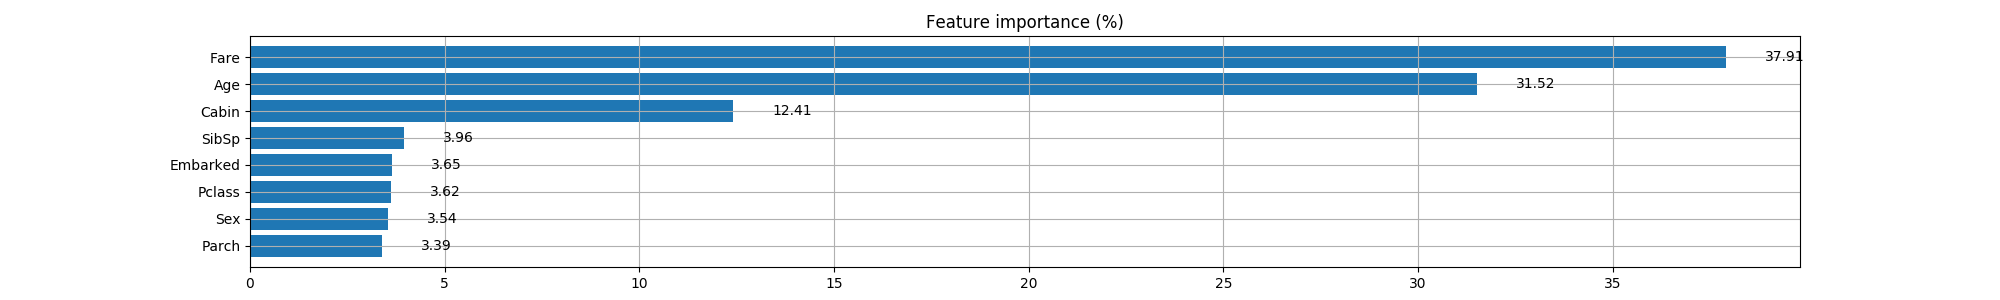

In [12]:
opt.evaluate(best, df)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8991239932238378, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8634579512497651, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}


MEAN SCORE : accuracy = 0.8406440273680247
VARIANCE : 0.020150211634093307 (fold 1 = 0.8268156424581006, fold 2 = 0.8651685393258427, fold 3 = 0.8258426966292135, fold 4 = 0.8202247191011236, fold 5 = 0.86

0.8406440273680247